In [2]:
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
import ba_utils               # bundle adjustment tools
import vistools               # display tools
import utils                  # IO tools
import srtm4                  # SRTM tools
import rectification          # rectification tools
import stereo                 # stereo tools
import triangulation          # triangulation tools
from vistools import printbf  # boldface print

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
%matplotlib inline
np.set_printoptions(linewidth=150)

### Load data and set AOI

- Lists available images and sorts them according to the acquisition date
- Loads RPC coefficients from the images
- Displays Geographical footprints
- Selects the Area Of Interest in World Geodetic System (WGS84) coordinates, i.e. lon-lat

In [2]:
# list the tiff images available in the remote folder
IARPAurl = 'http://menthe.ovh.hw.ipol.im:80/IARPA_data/cloud_optimized_geotif'
myimages = utils.listFD(IARPAurl, 'TIF')

# sort the images by acquisition date
myimages = sorted(myimages, key=utils.acquisition_date)
myimages.pop(11)
myimages.pop(13)
myimages.pop(19)
print('Found {} images'.format(len(myimages)))

# select the number of cameras for the current run
#myimages = myimages[37:43]
n_cam = len(myimages)
print('Number of images to be used:', n_cam)

# load RPC coefficients
myrpcs = [utils.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

# creates an interactive map and returns a map handle to interact with it.
mymap = vistools.clickablemap(zoom=12)
display(mymap)

# display the footprint polygons of the satellite images 
for f in range(n_cam):    
    footprint = utils.get_image_longlat_polygon(myimages[f])
    mymap.add_GeoJSON(footprint)

# set the coordinates of the area of interest as a GeoJSON polygon (Buenos aires AOI)
aoi_buenos_aires = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                                     [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
aoi_buenos_aires['center'] = np.mean(aoi_buenos_aires['coordinates'][0][:4], axis=0).tolist() # add center field

# center the map on the center of the footprint
mymap.center = np.mean(footprint['coordinates'][0][:4], axis=0).tolist()[::-1]

# add a polygon and center the map
mymap.add_GeoJSON(aoi_buenos_aires)  # this draws the polygon described by aoi
mymap.center = aoi_buenos_aires['center'][::-1]  # aoi_buenos_aires['coordinates'][0][0][::-1] 

# get the altitude of the center of the AOI
lon, lat = aoi_buenos_aires['center']
z = srtm4.srtm4(lon, lat)

Found 47 images
Number of images to be used: 47
Finished loading RPC coefficients


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Set output directory

In [3]:
# all outputs of the experiment will be saved in this directory

input_dir = 'ba_experiments/50pairs_iarpa'

if not os.path.isdir(input_dir):
    os.mkdir(input_dir)

### Compute point clouds for all pairs

In [4]:
from PIL import Image

# get a dense point cloud for all possible pairs
list_of_pairs = ba_utils.get_predefined_pairs('order_using_completeness.txt')
#list_of_pairs = ba_utils.get_predefined_pairs('ba_experiments/pairs/order_using_sift.txt')

if not os.path.isdir(input_dir+'/clouds'):
    os.mkdir(input_dir+'/clouds')

for pair in list_of_pairs:
    idx_a, idx_b = pair
    print('Pocessing pair ({},{})...'.format(idx_a, idx_b))
    rect1, rect2, S1, S2, dmin, dmax, PA, PB = rectification.rectify_aoi(myimages[idx_a], myimages[idx_b], aoi_buenos_aires)
    LRS, _, _ = stereo.compute_disparity_map(rect1, rect2, dmin-20, dmax+20 , cost='census')
    xyz = triangulation.triangulate_disparities(LRS, myrpcs[idx_a], myrpcs[idx_b], S1, S2, PA, PB)
    emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi)
    ba_utils.write_point_cloud_ply(input_dir+'/clouds/dense_cloud_{:02}_{:02}.ply'.format(idx_a, idx_b), xyz)
    print('Done!\n')


Pocessing pair (38,39)...
t=1.0492 done building CV
t=2.9801 done sgmfilter
t=3.3697 done aggregation and WTA refinement
t=0.9740 done building CV
t=2.7093 done sgmfilter
t=2.8370 done aggregation and WTA refinement
Done!

Pocessing pair (37,38)...
t=0.9874 done building CV
t=2.8430 done sgmfilter
t=2.9747 done aggregation and WTA refinement
t=0.8860 done building CV
t=2.6145 done sgmfilter
t=2.7431 done aggregation and WTA refinement
Done!

Pocessing pair (36,37)...
t=0.9982 done building CV
t=2.8018 done sgmfilter
t=2.9322 done aggregation and WTA refinement
t=0.8698 done building CV
t=2.7233 done sgmfilter
t=2.8500 done aggregation and WTA refinement
Done!

Pocessing pair (41,42)...
t=0.3674 done building CV
t=1.6124 done sgmfilter
t=1.6604 done aggregation and WTA refinement
t=0.3081 done building CV
t=1.4493 done sgmfilter
t=1.4958 done aggregation and WTA refinement
Done!

Pocessing pair (35,36)...
t=0.9977 done building CV
t=2.9932 done sgmfilter
t=3.1164 done aggregation and WT

Done!

Pocessing pair (0,1)...
t=0.9161 done building CV
t=2.7012 done sgmfilter
t=2.8175 done aggregation and WTA refinement
t=0.8146 done building CV
t=2.6265 done sgmfilter
t=2.7418 done aggregation and WTA refinement
Done!

Pocessing pair (26,30)...
t=1.3365 done building CV
t=3.5962 done sgmfilter
t=3.7695 done aggregation and WTA refinement
t=1.2409 done building CV
t=3.5807 done sgmfilter
t=3.7544 done aggregation and WTA refinement
Done!

Pocessing pair (17,24)...
t=1.2069 done building CV
t=3.3668 done sgmfilter
t=3.5267 done aggregation and WTA refinement
t=1.1014 done building CV
t=3.2663 done sgmfilter
t=3.4217 done aggregation and WTA refinement
Done!

Pocessing pair (13,29)...
t=1.7536 done building CV
t=4.5197 done sgmfilter
t=4.7137 done aggregation and WTA refinement
t=1.3909 done building CV
t=4.0546 done sgmfilter
t=4.2567 done aggregation and WTA refinement
Done!

Pocessing pair (4,40)...
t=1.0447 done building CV
t=2.9646 done sgmfilter
t=3.0984 done aggregation an

### Postprocess output DSMs

In [5]:
from PIL import Image
import re
import subprocess

if not os.path.isdir(input_dir+'/dsm'):
    os.mkdir(input_dir+'/dsm')
if not os.path.isdir(input_dir+'/cdsm'):
    os.mkdir(input_dir+'/cdsm')
if not os.path.isdir(input_dir+'/mcdsm'):
    os.mkdir(input_dir+'/mcdsm')
if not os.path.isdir(input_dir+'/rcdsm'):
    os.mkdir(input_dir+'/rcdsm')
if not os.path.isdir(input_dir+'/output'):
    os.mkdir(input_dir+'/output')
if not os.path.isdir(input_dir+'/ncc_transform'):
    os.mkdir(input_dir+'/ncc_transform')

# use the aoi to set the limits of the grid where the point clouds will be projected to DSMs
emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi_buenos_aires)
px_size = 0.300000011920929 # to set the DSMs resolution

# project all point colouds to DSMs
print('Creating DSMs...')
ply_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/clouds')][0]
for filename in ply_files:
    xyz = ba_utils.read_point_cloud_ply(input_dir+'/clouds/'+filename)
    dem, dem_nan, dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=px_size)
    im = Image.fromarray(dem_nan)
    im.save(input_dir+'/dsm/dsm_{}.tif'.format(os.path.splitext(filename[12:])[0]))
print('Done!\n')
    
# post-process DSMs
print('Post-processing DSMs...')
dsm_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/dsm')][0]
for filename in dsm_files:
    dsm = input_dir+'/dsm/'+filename # original dsm
    
    # small hole interpolation by closing
    cdsm = input_dir+'/cdsm/c'+filename  # dsm after closing
    os.system('bin/morsi square closing {0} | bin/plambda {0} - "x isfinite x y isfinite y nan if if" -o {1}'.format(dsm, cdsm))
       
    # larger holes with min interpolation
    mcdsm = input_dir+'/mcdsm/mc'+filename  # dsm after closing and min interpolation
    os.system('bin/bdint5pc -a min {} {}'.format(cdsm, mcdsm))
print('Done!\n')

a, b = list_of_pairs[0] # take first pair as reference
ref_dsm = input_dir+'/dsm/dsm_{:02}_{:02}.tif'.format(a,b)
ref_cdsm = input_dir+'/cdsm/cdsm_{:02}_{:02}.tif'.format(a,b)
ref_mcdsm = input_dir+'/mcdsm/mcdsm_{:02}_{:02}.tif'.format(a,b)
print('Selected pair {:02}_{:02} as the reference one'.format(a,b))

# align DSMs using 3D translations maximizing the NCC of their geometry
print('Aligning DSMs...')
for filename in dsm_files:
    cdsm = input_dir+'/cdsm/c'+filename
    mcdsm = input_dir+'/mcdsm/mc'+filename
    rcdsm = input_dir+'/rcdsm/rc'+filename
    trans = input_dir+'/ncc_transform/t_'+os.path.splitext(filename)[0]+'.txt'  

    # compute horizontal registration on the interpolated DSMs
    os.system('bin/ncc_compute_shift {} {} 5 > {}'.format(ref_mcdsm, mcdsm, trans))
    dx, dy = np.loadtxt(trans)[:2]

    # compute vertical registration on the original DSMs
    os.system('bin/ncc_compute_shift {} {} 5 {} {} > {}'.format(ref_cdsm, cdsm, dx, dy, trans))

    # apply the registration
    os.system('bin/ncc_apply_shift {} `cat {}` {}'.format(cdsm, trans, rcdsm))
print('Done!\n')

raw dsm created!
selected pair 38_39 as the reference one
dsm registered!


### Fuse output DSMs

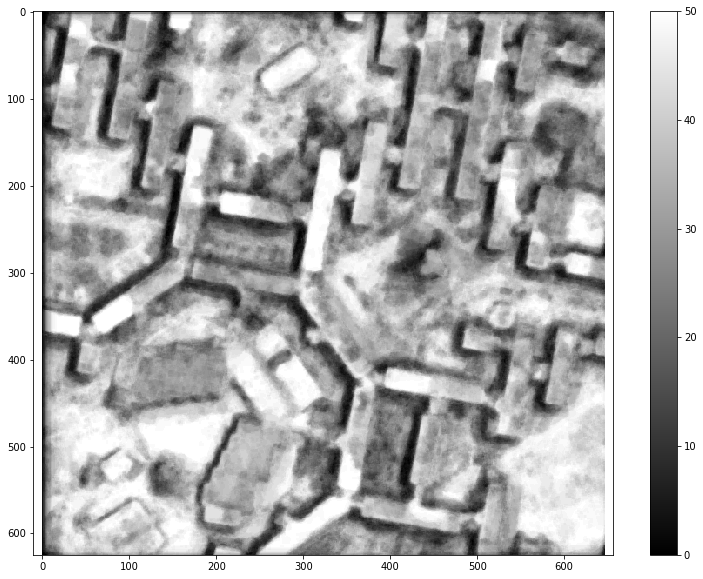

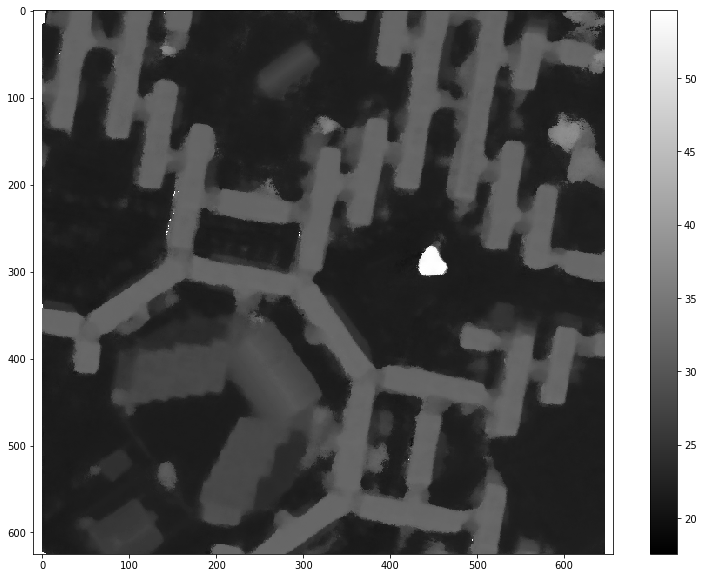

In [5]:
from PIL import Image
import re
import subprocess

#input_dir = 'ba_experiments/50pairs_iarpa'

# stack the N output DSMs in a WxHxN grid
rcdsm_files = [filenames for (dirpath, dirnames, filenames) in os.walk(input_dir+'/rcdsm')][0]
olist = [input_dir+'/rcdsm/'+filename for filename in rcdsm_files]
u=[]
for ofile in olist:
    u.append(np.array(Image.open(ofile)))
stacked_rcdsm = np.dstack(u)

# pointwise median to fuse all DSMs
fusion_result = np.nanmedian(stacked_rcdsm, axis=2)

# visualize the number of samples per pixel
nan_idx = np.isnan(stacked_rcdsm)
obs_per_px = np.sum((~nan_idx).astype(int), axis=2).astype(float)
            
vistools.display_imshow(obs_per_px)
vistools.display_imshow(fusion_result)
im = Image.fromarray(fusion_result)
im.save(input_dir+'/output/fused_dsm.tif')

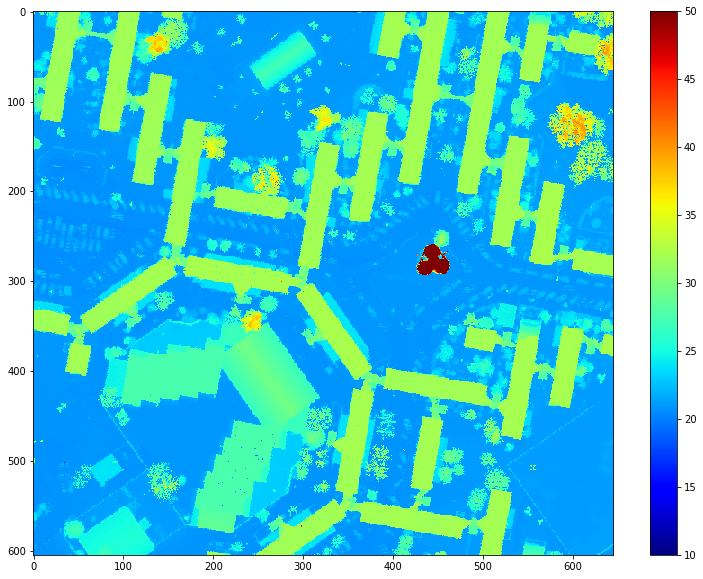

In [6]:
# prepare GT dem to obtain performance score

from PIL import Image

# set the coordinates of the area of interest as a GeoJSON polygon (Buenos aires AOI)
aoi_buenos_aires = {'coordinates': [[[-58.585185, -34.490883], [-58.585185, -34.48922 ], [-58.583104, -34.48922 ],
                                     [-58.583104, -34.490883], [-58.585185, -34.490883]]], 'type': 'Polygon'}
aoi_buenos_aires['center'] = np.mean(aoi_buenos_aires['coordinates'][0][:4], axis=0).tolist() # add center field
emin, emax, nmin, nmax = utils.utm_bounding_box_from_lonlat_aoi(aoi_buenos_aires)

# read the ground truth geotiff  
gt_dsm = np.array(Image.open('ba_experiments/gt_dsm.tif'))
lon, lat = np.array([-58.585185]), np.array([-34.48922])
east, north = utils.utm_from_lonlat(lon, lat)

# write the necessary data from gdalinfo (northing (y) needs to be expressed in negative coordinates)
epsg, x, y, px_size = 32721, 354449.320, 6182457.920 - 10000000, 0.300000011920929

# attention: the top-left corner from the gt tiff and the one from the aoi are not exactly coincident

# save the gt geotiff but this time with northing in negative coordinates
ba_utils.save_geotiff('ba_experiments/gt_dsm2.tif', gt_dsm.astype(np.float64), epsg, x, y, r=px_size)

# elevate the geotiff we just wrote and write the point cloud in a ply file
os.system('bin/elevate ba_experiments/gt_dsm2.tif > ba_experiments/gt_cloud.txt')
xyz = ba_utils.read_point_cloud_txt('ba_experiments/gt_cloud.txt')
ba_utils.write_point_cloud_ply('ba_experiments/gt_cloud.ply', xyz)

# project the recently created point cloud into the aoi and create a dem
xyz = ba_utils.read_point_cloud_ply('ba_experiments/gt_cloud.ply')
dem_3,dem_nan,dem_std = triangulation.project_cloud_into_utm_grid(xyz, emin, emax, nmin, nmax, resolution=px_size)

# save the dem as the new ready-to-be-used gt
im = Image.fromarray(dem_nan)
im.save('ba_experiments/gt_dsm_nan.tif')

# filter those values where we do not have gt available
rows_with_gt = ~np.all(np.isnan(dem_nan), axis=1)
cols_with_gt = ~np.all(np.isnan(dem_nan), axis=0)
dem_3 = dem_3[rows_with_gt, :]
dem_3 = dem_3[:, cols_with_gt]
im = Image.fromarray(dem_3)
im.save('ba_experiments/gt_dsm3.tif')

vistools.display_imshow(dem_3, cmap='jet', range=(10,50))

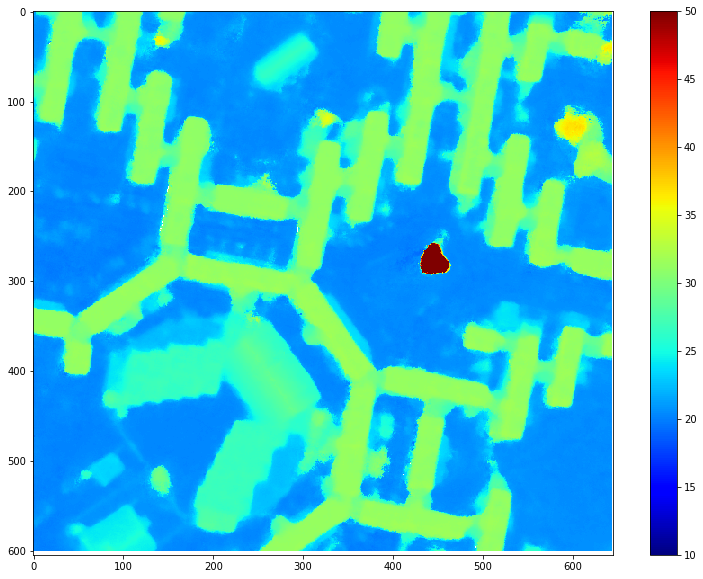

In [7]:
# prepare SOL dem to obtain performance score

# read fused and gt dem
out_dsm = np.array(Image.open(input_dir+'/output/fused_dsm.tif'))
gt_dsm  = np.array(Image.open('ba_experiments/gt_dsm_nan.tif'))

# filter those values where we do not have gt available
rows_with_gt = ~np.all(np.isnan(gt_dsm), axis=1)
cols_with_gt = ~np.all(np.isnan(gt_dsm), axis=0)
out_dsm2 = out_dsm[rows_with_gt, :]
out_dsm2 = out_dsm2[:, cols_with_gt]
im = Image.fromarray(out_dsm2)
im.save(input_dir+'/output/fused_dsm2.tif')

out_dsm = input_dir+'/output/fused_dsm2.tif'
gt_dsm  = 'ba_experiments/gt_dsm3.tif'

# compute horizontal registration on the interpolated DSMs
trans = input_dir+'/t_sol.txt'
os.system('bin/ncc_compute_shift {} {} 5 > {}'.format(gt_dsm, out_dsm, trans))
dx, dy = np.loadtxt(trans)[:2]

# compute vertical registration on the original DSMs
os.system('bin/ncc_compute_shift {} {} 5 {} {} > {}'.format(gt_dsm, out_dsm, dx, dy, trans))

# apply the registration
os.system('bin/ncc_apply_shift {} `cat {}` {}'.format(out_dsm, trans, input_dir+'/sol_dsm.tif'))

# copy geotiff properties from the gt dsm to the sol dsm
#os.system('python gdalcopyproj.py {} {}'.format(gt_dsm, input_dir+'/sol_dsm.tif'))

sol_dsm = np.array(Image.open(input_dir+'/sol_dsm.tif'))
vistools.display_imshow(sol_dsm, cmap='jet', range=(10,50))

score: 70.81584876798412
nan: 0.977918788219938
mean_e: 1.4516835
median_e: 0.6164484
std_e: 2.243243


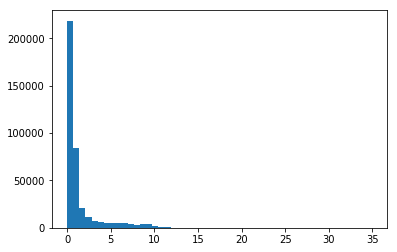

In [9]:
# compute score
from PIL import Image

input_dir = 'ba_experiments/50pairs_iarpa'

dem_gt = np.array(Image.open('ba_experiments/gt_dsm3.tif'))
dem_sol = np.array(Image.open(input_dir+'/sol_dsm.tif'))

# compute mse and completness (i.e. % of px with error lower than 1 m)
# first remove possible nans from the solution
idx = ~np.isnan(dem_sol)
dem_gt2, dem_sol2 = dem_gt[idx], dem_sol[idx]
total_px = dem_gt2.shape[0]
nan_values = 100 - ((total_px/ (dem_gt.shape[0] * dem_gt.shape[1]) ) * 100)
mean_e = np.mean((abs(dem_gt2 - dem_sol2)))
median_e = np.median(abs(dem_gt2 - dem_sol2))
std_e = np.std(abs(dem_gt2 - dem_sol2))
completness = sum( (abs(dem_gt2 - dem_sol2) < 1.0).astype(int) ) / total_px * 100

plt.hist(abs(dem_gt2 - dem_sol2), bins=50) 

print('score:', completness)
print('nan:', nan_values)
print('mean_e:', mean_e)
print('median_e:', median_e)
print('std_e:', std_e)


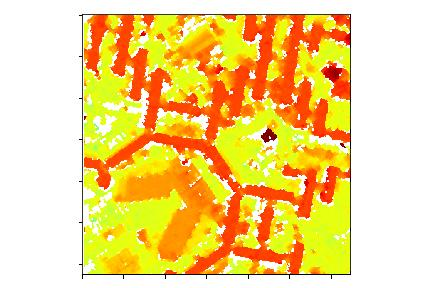
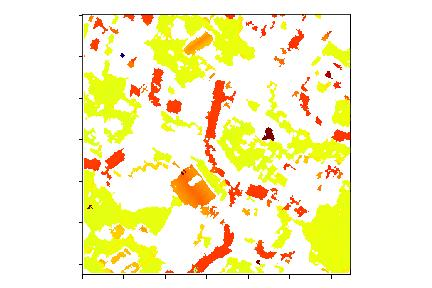
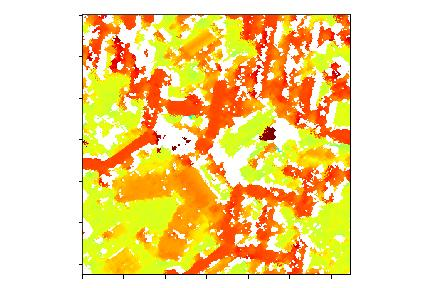
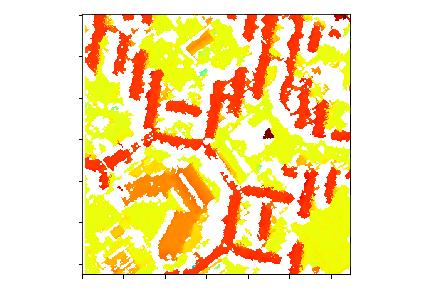
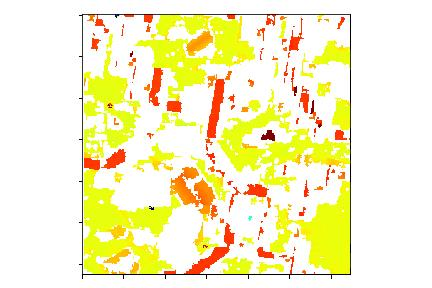
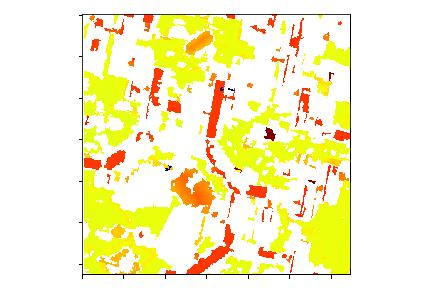
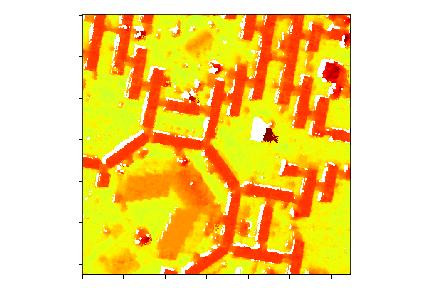
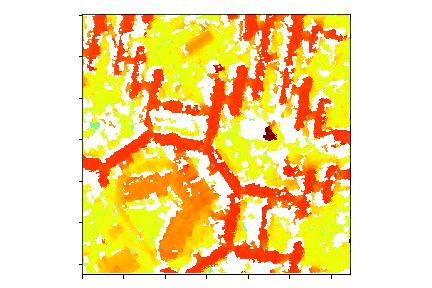
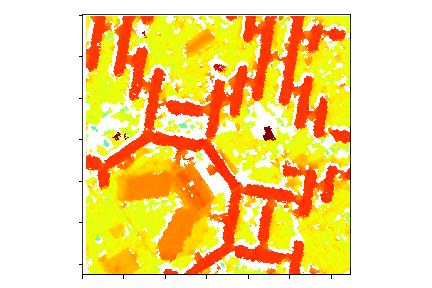
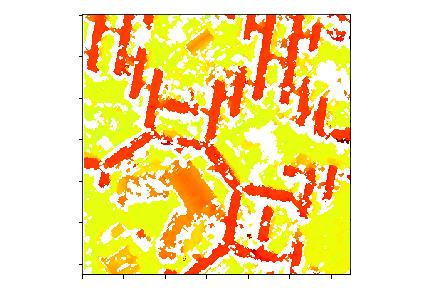
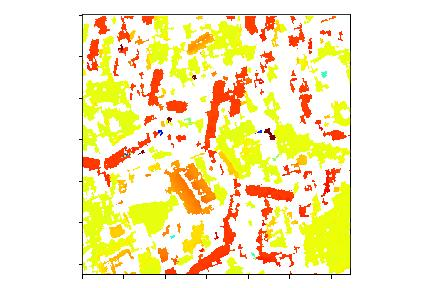
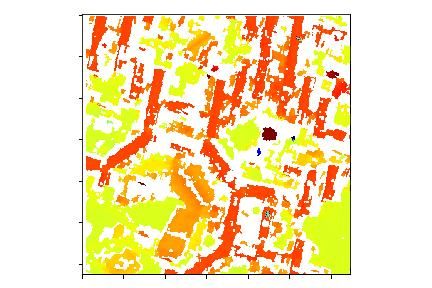
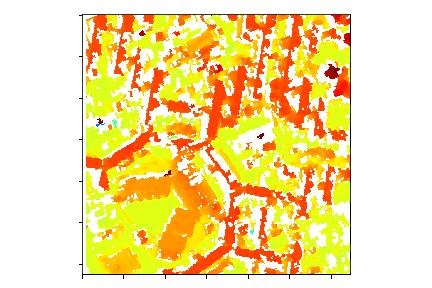
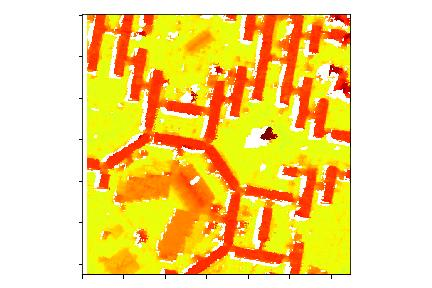
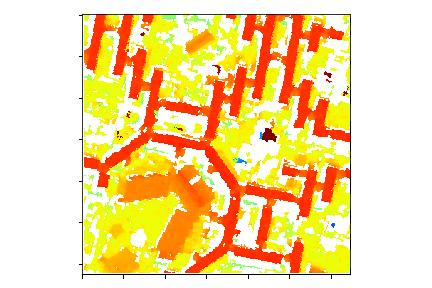
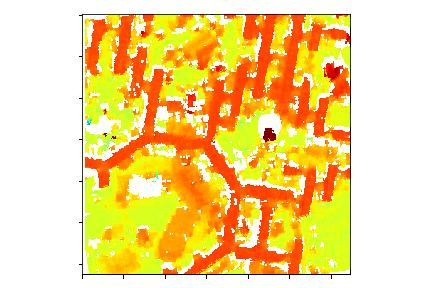
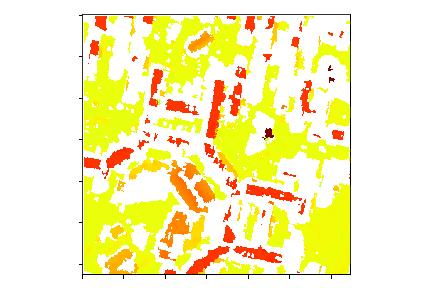
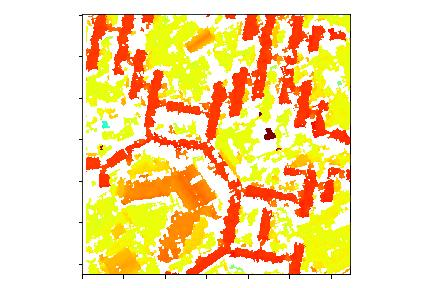
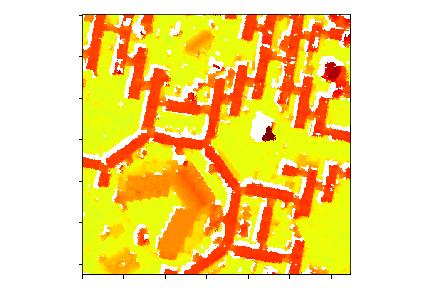
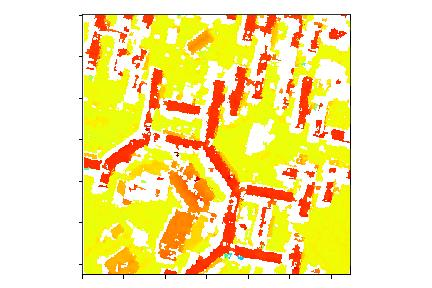
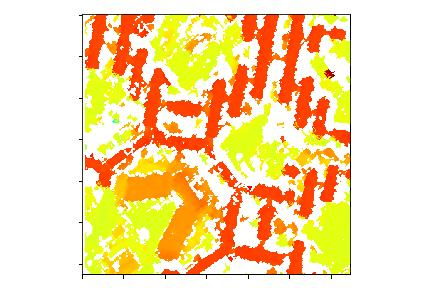
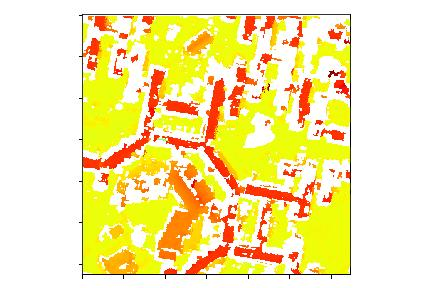
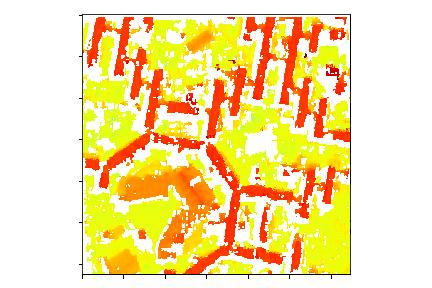
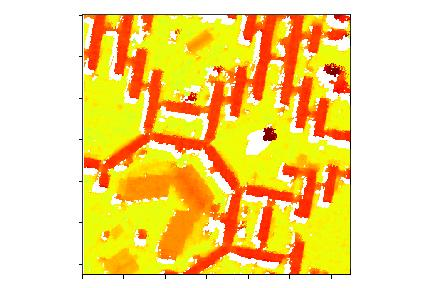
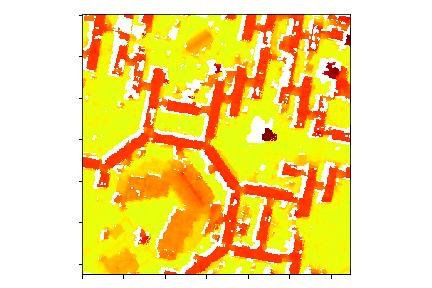
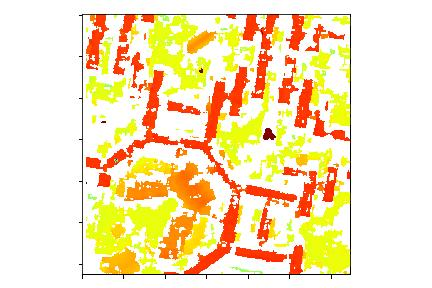
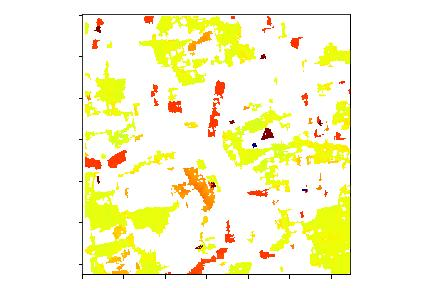
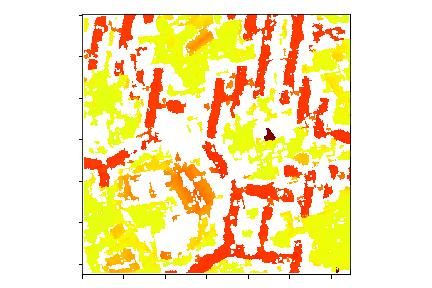
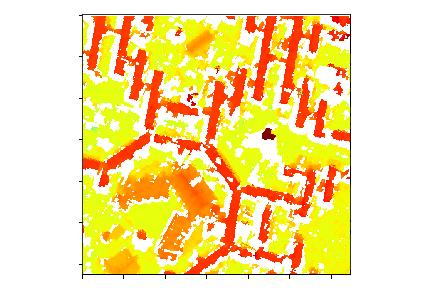
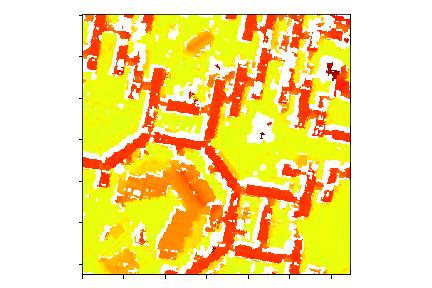
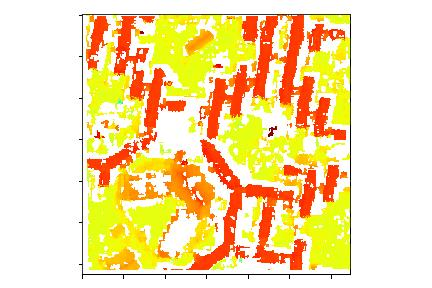
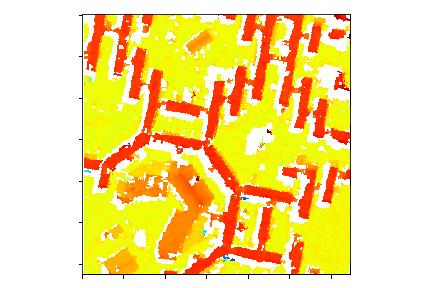
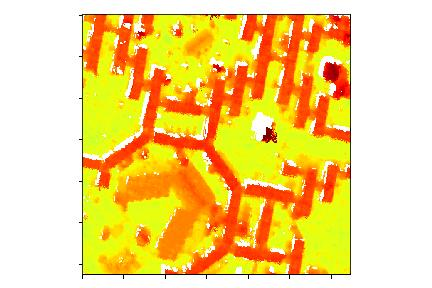
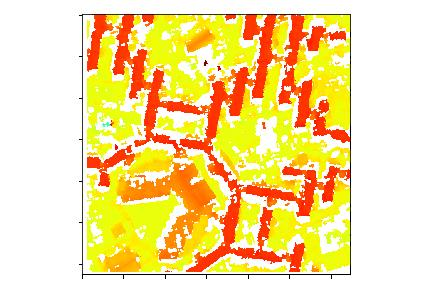
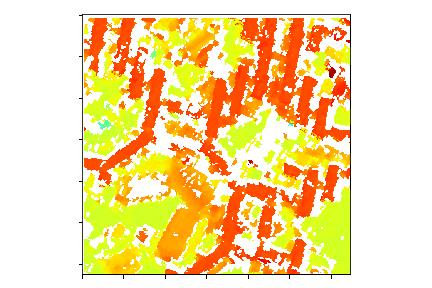
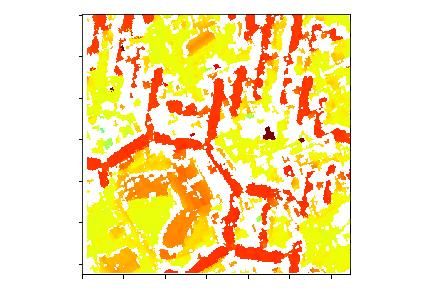
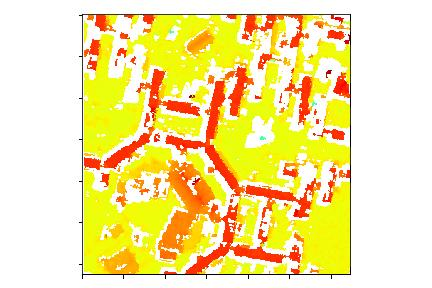
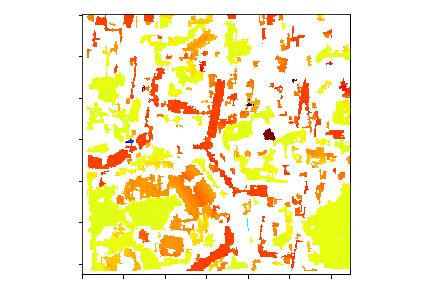
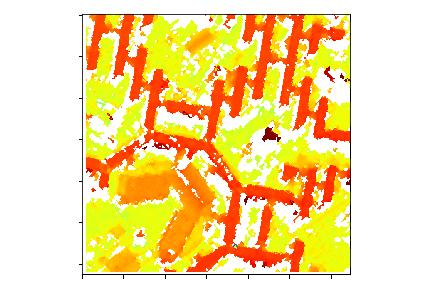
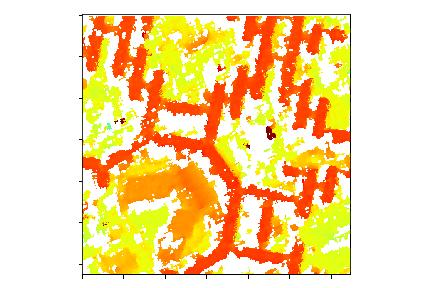
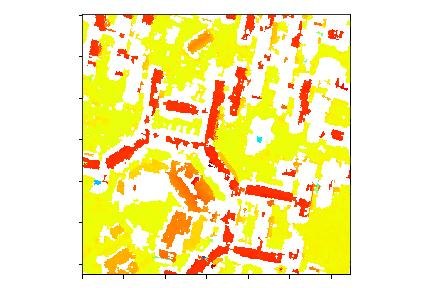
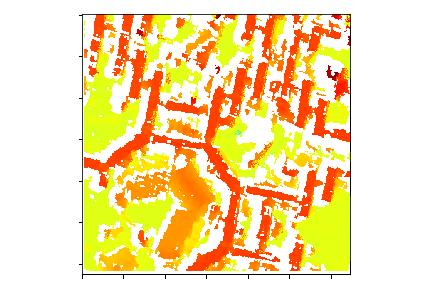
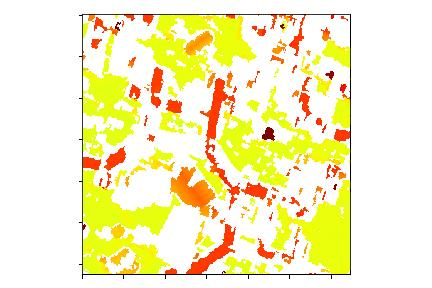
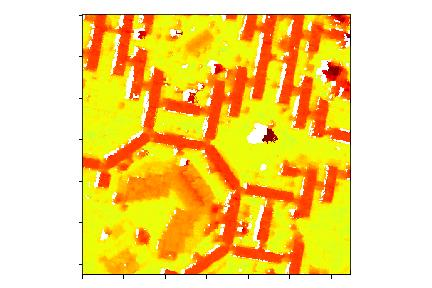
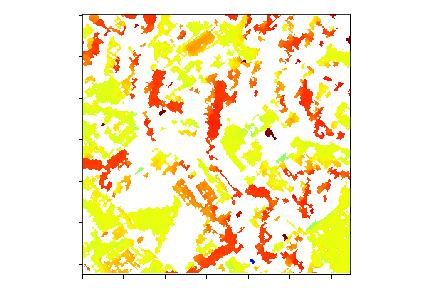
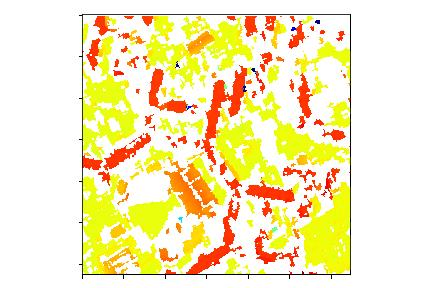
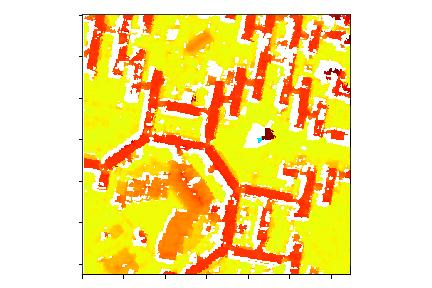
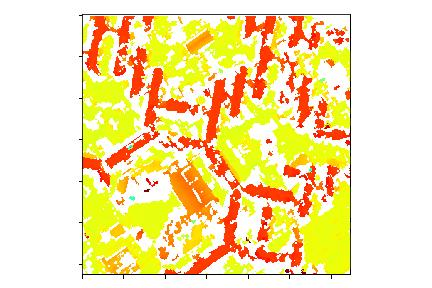
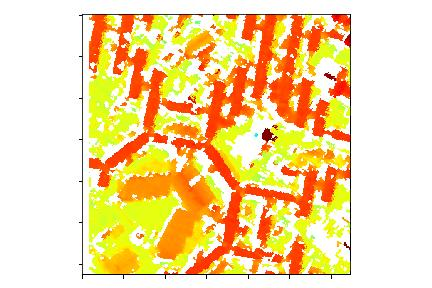
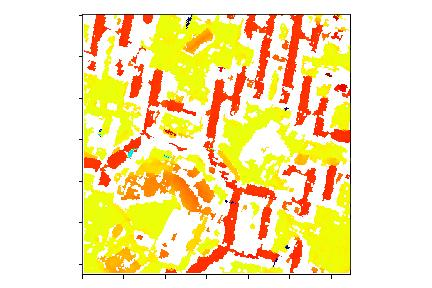

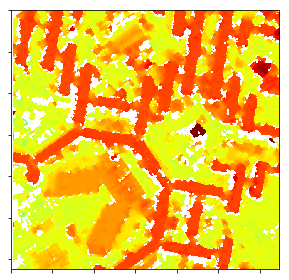

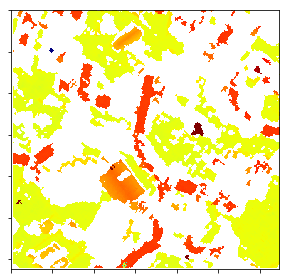

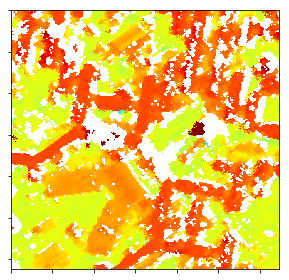

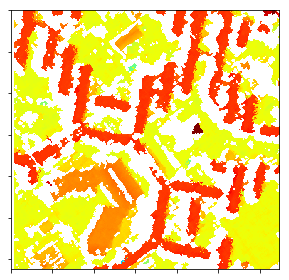

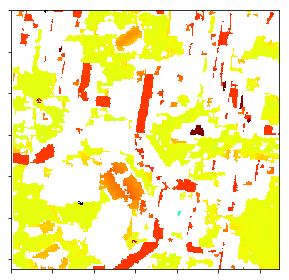

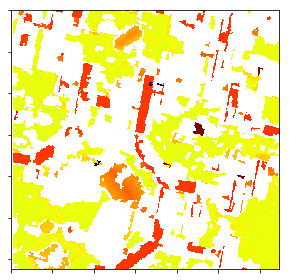

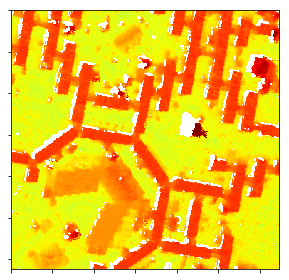

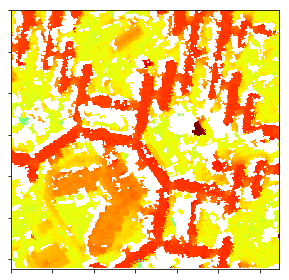

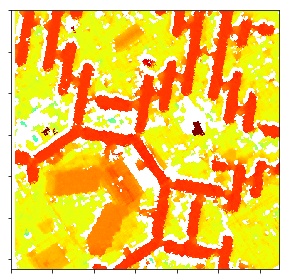

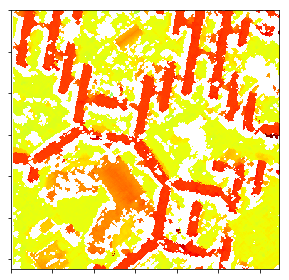

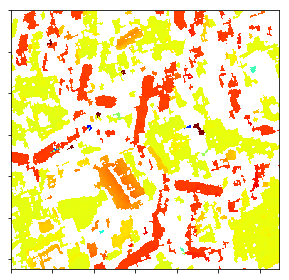

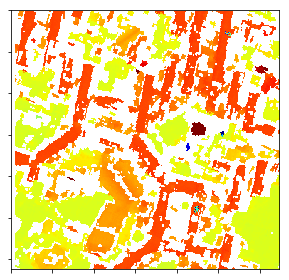

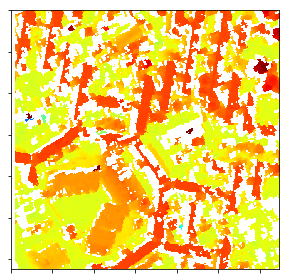

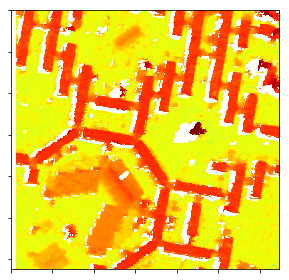

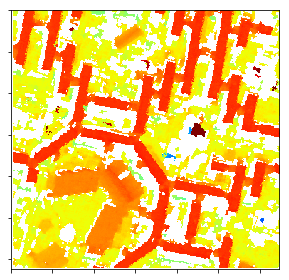

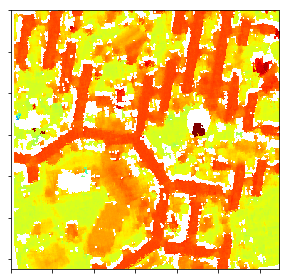

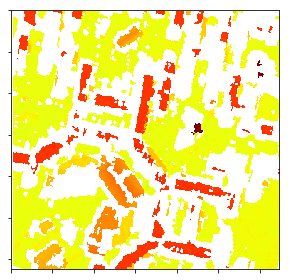

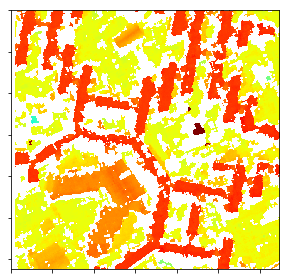

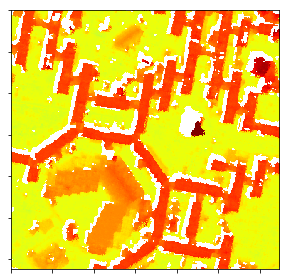

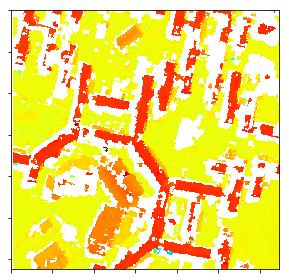

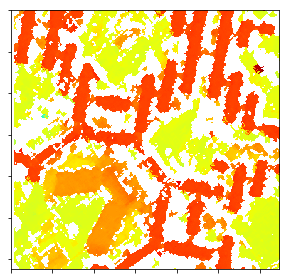

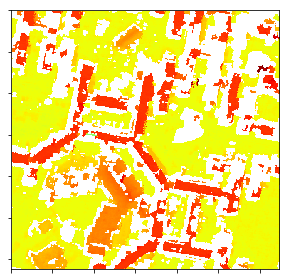

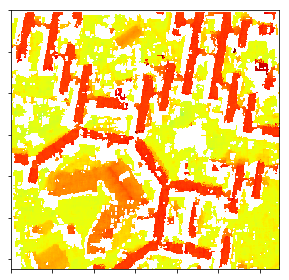

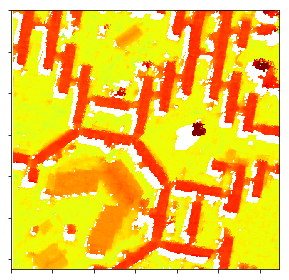

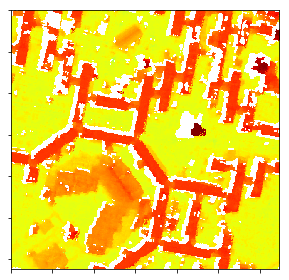

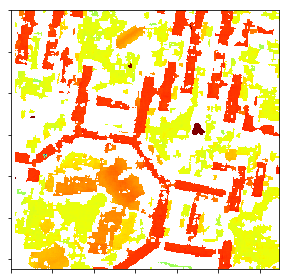

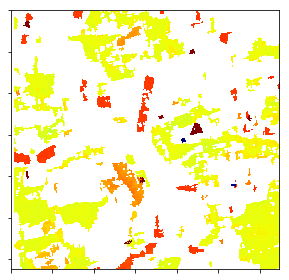

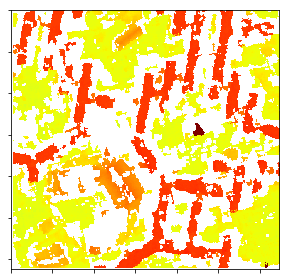

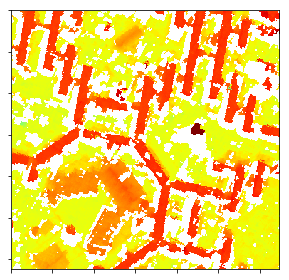

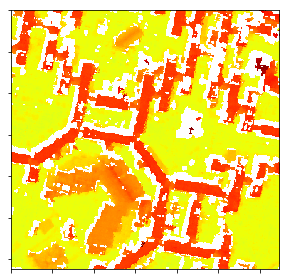

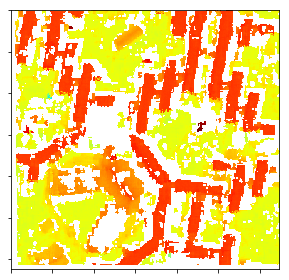

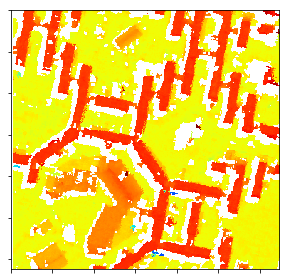

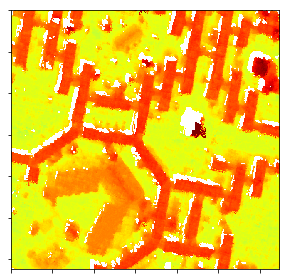

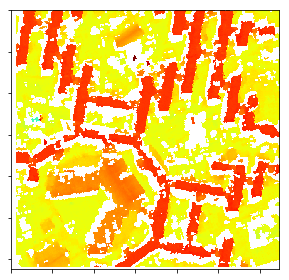

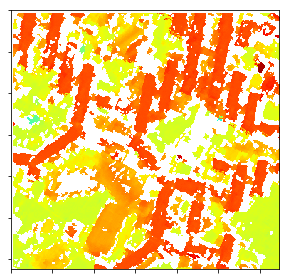

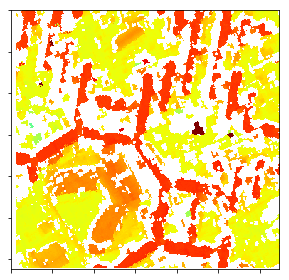

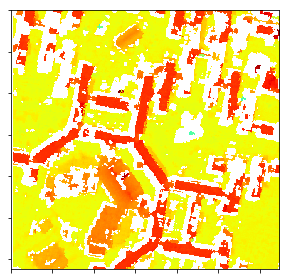

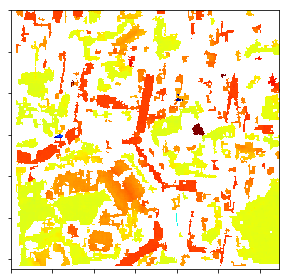

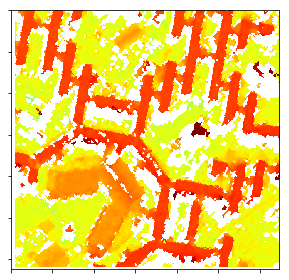

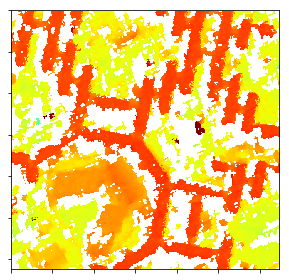

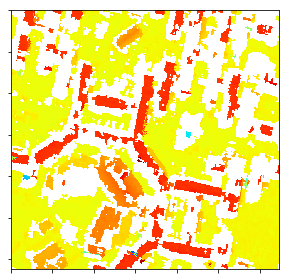

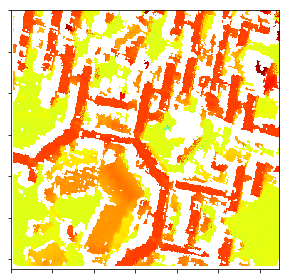

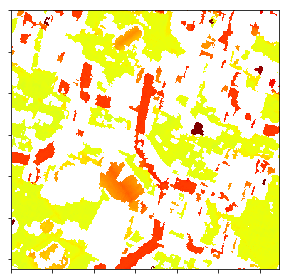

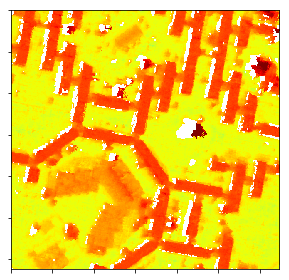

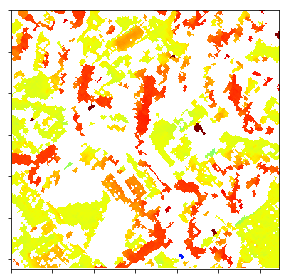

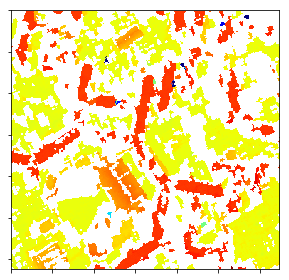

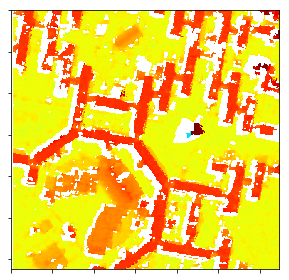

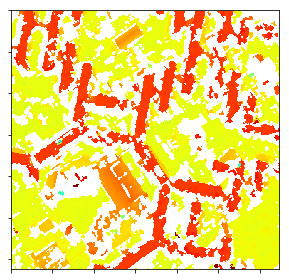

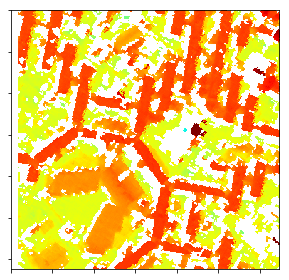

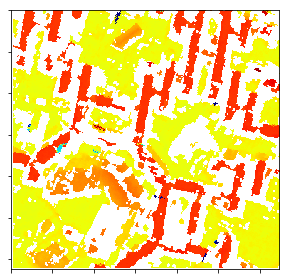

In [11]:
# visualize registered DSMs

from PIL import Image

path = input_dir+'/rcdsm'
dsm_files = [filenames for (dirpath, dirnames, filenames) in os.walk(path)][0]

features_on_img = []
for filename in dsm_files:
    current_dem = np.array(Image.open(path+'/'+filename))
    fig = plt.figure()
    fig.add_subplot(111)
    plt.imshow(current_dem.squeeze(), cmap='jet', vmin=-10, vmax=40) 
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])
    plt.tight_layout()
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    features_on_img.append(data)

vistools.display_gallery(features_on_img)